In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [53]:
df_V1=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V1.csv")
df_V2=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V2.csv")
df_V3=pd.read_csv("Data/Preprocessed/Rockburst_in_Tunnel_V3.csv")

In [54]:
df_V1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Energy_Unit              91 non-null     int64  
 1   Energy_density_Joule     91 non-null     float64
 2   Volume_m3                91 non-null     float64
 3   Event_freq_unit_per_day  91 non-null     float64
 4   Energy_Joule_per_day     91 non-null     float64
 5   Volume_m3_per_day        91 non-null     float64
 6   Duration_days            91 non-null     int64  
 7   Intensity_Level          91 non-null     object 
 8   Intensity_Level_encoded  91 non-null     int64  
 9   Energy_per_Volume        91 non-null     float64
 10  Energy_per_Duration      91 non-null     float64
 11  Volume_Change_Rate       91 non-null     float64
dtypes: float64(8), int64(3), object(1)
memory usage: 8.7+ KB


In [55]:
df_V2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Energy_Unit                  91 non-null     int64  
 1   Energy_density_Joule         91 non-null     float64
 2   Volume_m3                    91 non-null     float64
 3   Event_freq_unit_per_day      91 non-null     float64
 4   Energy_Joule_per_day         91 non-null     float64
 5   Volume_m3_per_day            91 non-null     float64
 6   Duration_days                91 non-null     int64  
 7   Intensity_Level              91 non-null     object 
 8   Intensity_Level_encoded      91 non-null     int64  
 9   Energy_per_Volume            91 non-null     float64
 10  Energy_per_Duration          91 non-null     float64
 11  Volume_Change_Rate           91 non-null     float64
 12  Energy_Unit_log              91 non-null     float64
 13  Energy_density_sqr    

In [56]:
df_V3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1000 non-null   int64  
 1   Duration_days                1000 non-null   float64
 2   Energy_Unit_log              1000 non-null   float64
 3   Energy_density_sqr           1000 non-null   float64
 4   Volume_sqr                   1000 non-null   float64
 5   Event_freq_unit_per_day_log  1000 non-null   float64
 6   Energy_Joule_per_day_sqr     1000 non-null   float64
 7   Volume_m3_per_day_sqr        1000 non-null   float64
 8   Energy_per_Volume_log        1000 non-null   float64
 9   Energy_per_Duration_log      1000 non-null   float64
 10  Volume_Change_Rate_log       1000 non-null   float64
 11  Intensity_Level_encoded      1000 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 93.9 KB


In [57]:
exclude_cols = ["Intensity_Level","Intensity_Level_encoded"]           
features_V1 = [col for col in df_V1.columns if col not in exclude_cols]

In [58]:
def train_models(df, dataset_name,features):
    # 1. Features & Target
    X = df[features]
    y = df['Intensity_Level_encoded']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler=StandardScaler()
    X_train_scaled=scaler.fit_transform(X_train)
    X_test_scaled=scaler.fit_transform(X_test)

    # 2. Models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=5000),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', probability=True, random_state=42),
        "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
    }

    results = {}

    # 3. Training & Evaluation
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, preds)
        results[name] = acc

        print(f"\n=== {dataset_name} | {name} ===")
        print("Accuracy:", round(acc, 4))
        print("Classification Report:\n", classification_report(y_test, preds))

        # Confusion Matrix
        cm = confusion_matrix(y_test, preds)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y),
                    yticklabels=np.unique(y))
        plt.title(f"{dataset_name} - {name} | Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    # Accuracy Comparison
    plt.figure(figsize=(8,5))
    models_name=list(results.keys())
    performance=list(results.values())
    sns.barplot(x=models_name, y=performance, palette='viridis',hue=models_name,legend=False)
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Comparison")
    plt.ylim(0, 1)
    plt.show()
    models_df = pd.DataFrame({
        "Model": models_name,
        "Accuracy": performance
    })

    return models_df,models,scaler



=== RockBurst V1 | Logistic Regression ===
Accuracy: 0.6316
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.33      0.20      0.25         5
           2       0.56      1.00      0.71         5
           3       1.00      0.50      0.67         2

    accuracy                           0.63        19
   macro avg       0.68      0.60      0.60        19
weighted avg       0.65      0.63      0.61        19



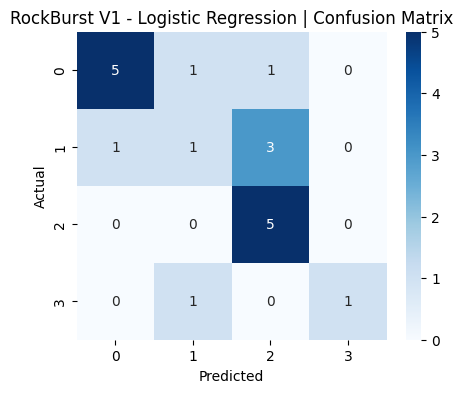


=== RockBurst V1 | Random Forest ===
Accuracy: 0.5263
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.40      0.40      0.40         5
           2       0.50      0.60      0.55         5
           3       1.00      0.50      0.67         2

    accuracy                           0.53        19
   macro avg       0.62      0.52      0.55        19
weighted avg       0.55      0.53      0.53        19



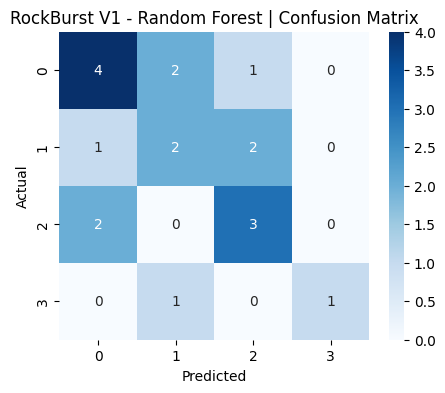


=== RockBurst V1 | SVM ===
Accuracy: 0.6842
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.50      0.20      0.29         5
           2       0.56      1.00      0.71         5
           3       1.00      0.50      0.67         2

    accuracy                           0.68        19
   macro avg       0.73      0.64      0.63        19
weighted avg       0.70      0.68      0.65        19



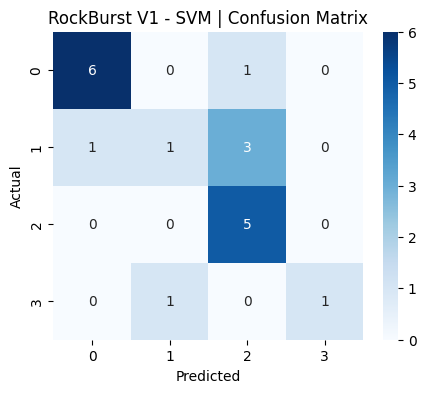


=== RockBurst V1 | XGBoost ===
Accuracy: 0.5263
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.40      0.40      0.40         5
           2       0.50      0.60      0.55         5
           3       1.00      0.50      0.67         2

    accuracy                           0.53        19
   macro avg       0.62      0.52      0.55        19
weighted avg       0.55      0.53      0.53        19



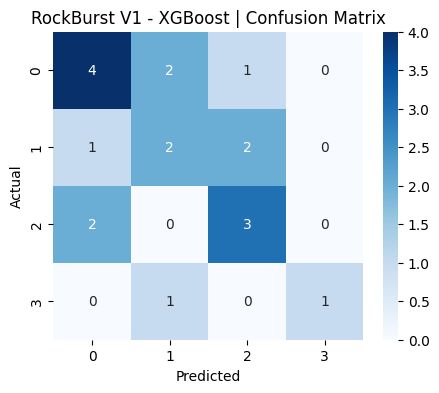

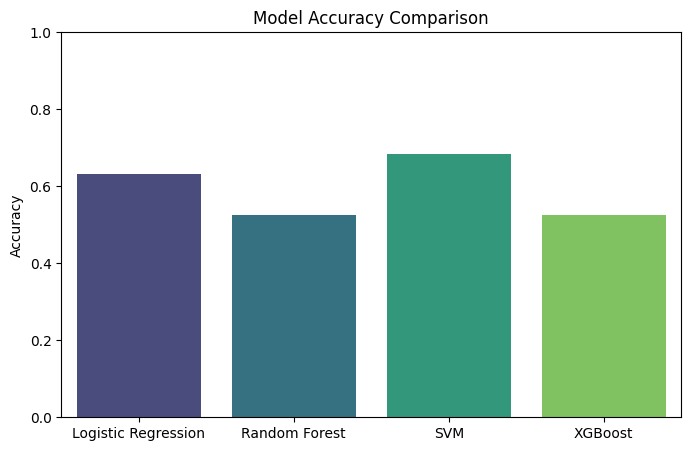

In [59]:
results_df_V1,models_V1,scaler_V1=train_models(df_V1,"RockBurst V1",features_V1)

In [60]:
results_df_V1.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy
2,SVM,0.684211
0,Logistic Regression,0.631579
1,Random Forest,0.526316
3,XGBoost,0.526316


In [61]:
df_V2.columns

Index(['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 'Volume_m3_per_day',
       'Duration_days', 'Intensity_Level', 'Intensity_Level_encoded',
       'Energy_per_Volume', 'Energy_per_Duration', 'Volume_Change_Rate',
       'Energy_Unit_log', 'Energy_density_sqr', 'Volume_sqr',
       'Event_freq_unit_per_day_log', 'Energy_Joule_per_day_sqr',
       'Volume_m3_per_day_sqr', 'Energy_per_Volume_log',
       'Energy_per_Duration_log', 'Volume_Change_Rate_log'],
      dtype='object')

In [62]:
exclude_cols = ['Energy_Unit', 'Energy_density_Joule', 'Volume_m3',
       'Event_freq_unit_per_day', 'Energy_Joule_per_day', 'Volume_m3_per_day',
       "Intensity_Level","Intensity_Level_encoded",'Energy_per_Volume', 
       'Energy_per_Duration', 'Volume_Change_Rate']           
features_V2 = [col for col in df_V2.columns if col not in exclude_cols]

In [63]:
features_V2

['Duration_days',
 'Energy_Unit_log',
 'Energy_density_sqr',
 'Volume_sqr',
 'Event_freq_unit_per_day_log',
 'Energy_Joule_per_day_sqr',
 'Volume_m3_per_day_sqr',
 'Energy_per_Volume_log',
 'Energy_per_Duration_log',
 'Volume_Change_Rate_log']


=== RockBurst V2 | Logistic Regression ===
Accuracy: 0.5263
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.25      0.20      0.22         5
           2       0.38      0.60      0.46         5
           3       1.00      0.50      0.67         2

    accuracy                           0.53        19
   macro avg       0.61      0.50      0.53        19
weighted avg       0.58      0.53      0.53        19



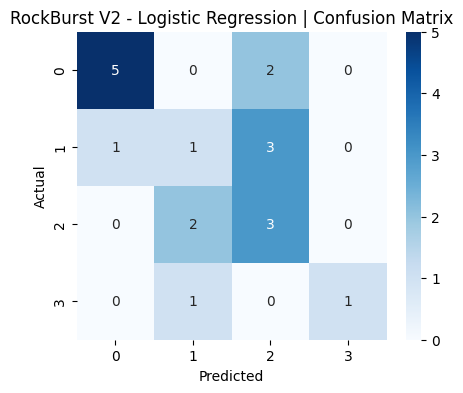


=== RockBurst V2 | Random Forest ===
Accuracy: 0.4737
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.20      0.20      0.20         5
           2       0.50      0.60      0.55         5
           3       1.00      0.50      0.67         2

    accuracy                           0.47        19
   macro avg       0.57      0.47      0.50        19
weighted avg       0.50      0.47      0.48        19



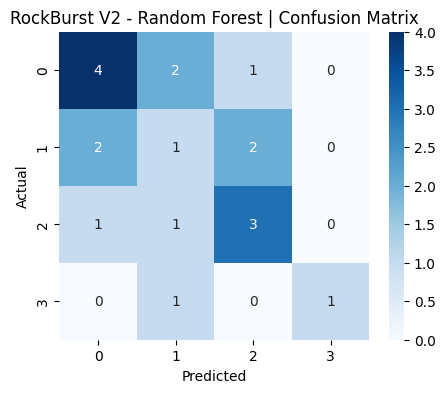


=== RockBurst V2 | SVM ===
Accuracy: 0.6316
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.33      0.20      0.25         5
           2       0.50      0.80      0.62         5
           3       1.00      0.50      0.67         2

    accuracy                           0.63        19
   macro avg       0.67      0.59      0.60        19
weighted avg       0.64      0.63      0.61        19



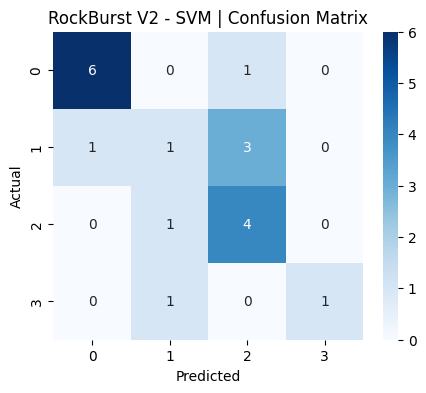


=== RockBurst V2 | XGBoost ===
Accuracy: 0.5789
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.50      0.60      0.55         5
           2       0.50      0.60      0.55         5
           3       1.00      0.50      0.67         2

    accuracy                           0.58        19
   macro avg       0.67      0.57      0.59        19
weighted avg       0.61      0.58      0.58        19



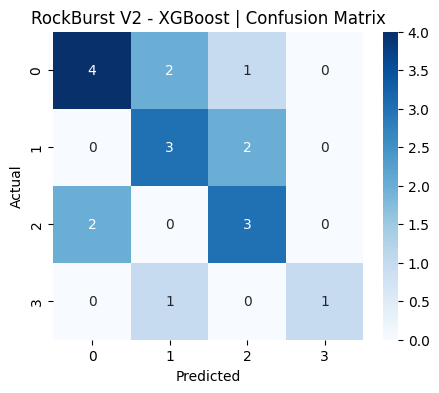

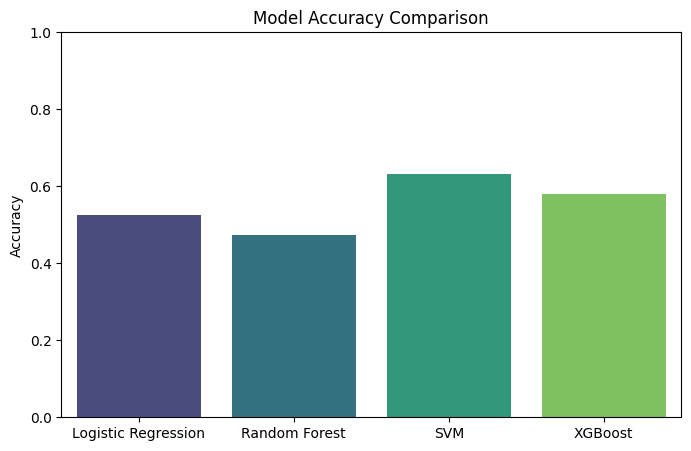

In [64]:
results_df_V2,models_V2,scaler_V2=train_models(df_V2,"RockBurst V2",features_V2)

In [65]:
results_df_V2.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy
2,SVM,0.631579
3,XGBoost,0.578947
0,Logistic Regression,0.526316
1,Random Forest,0.473684


In [66]:
df_V3.columns

Index(['Unnamed: 0', 'Duration_days', 'Energy_Unit_log', 'Energy_density_sqr',
       'Volume_sqr', 'Event_freq_unit_per_day_log', 'Energy_Joule_per_day_sqr',
       'Volume_m3_per_day_sqr', 'Energy_per_Volume_log',
       'Energy_per_Duration_log', 'Volume_Change_Rate_log',
       'Intensity_Level_encoded'],
      dtype='object')

In [67]:
df_V3.tail()

,Unnamed: 0,Duration_days,Energy_Unit_log,Energy_density_sqr,Volume_sqr,Event_freq_unit_per_day_log,Energy_Joule_per_day_sqr,Volume_m3_per_day_sqr,Energy_per_Volume_log,Energy_per_Duration_log,Volume_Change_Rate_log,Intensity_Level_encoded
995,995,10.972335,3.740695,35.667026,22.079842,1.554502,24.331815,13.388167,2.273566,1.565729,0.283558,3
996,996,6.032944,2.641912,19.400757,19.546223,1.157794,13.174651,13.333925,1.380637,1.149365,0.473281,1
997,997,3.985610,1.602740,21.052115,13.742537,0.693217,15.968415,9.599065,0.729438,0.694842,0.579941,1
998,998,1.957615,1.096796,3.673079,10.594030,0.685870,2.556864,8.718167,0.478529,0.691477,0.907408,0
999,999,10.012285,4.263561,37.667507,26.452653,2.080915,26.668638,17.263195,2.682782,2.086344,0.349463,3


In [68]:
exclude_cols = ['Unnamed: 0','Intensity_Level_encoded']           
features_V3 = [col for col in df_V3.columns if col not in exclude_cols]

In [69]:
features_V3

['Duration_days',
 'Energy_Unit_log',
 'Energy_density_sqr',
 'Volume_sqr',
 'Event_freq_unit_per_day_log',
 'Energy_Joule_per_day_sqr',
 'Volume_m3_per_day_sqr',
 'Energy_per_Volume_log',
 'Energy_per_Duration_log',
 'Volume_Change_Rate_log']


=== RockBurst V3 | Logistic Regression ===
Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        51
           1       0.76      0.70      0.73        50
           2       0.90      0.92      0.91        50
           3       1.00      1.00      1.00        49

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



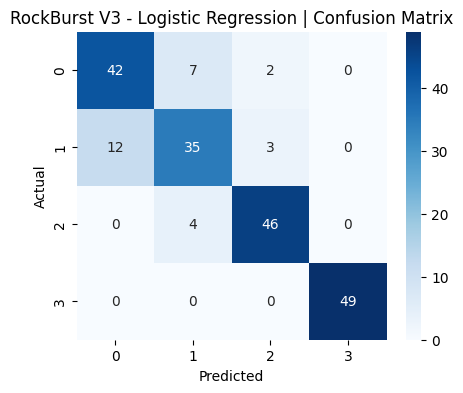


=== RockBurst V3 | Random Forest ===
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        49

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



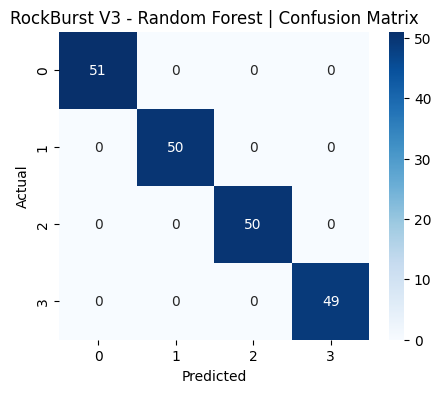


=== RockBurst V3 | SVM ===
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.82      0.87        51
           1       0.86      0.88      0.87        50
           2       0.91      0.98      0.94        50
           3       1.00      1.00      1.00        49

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



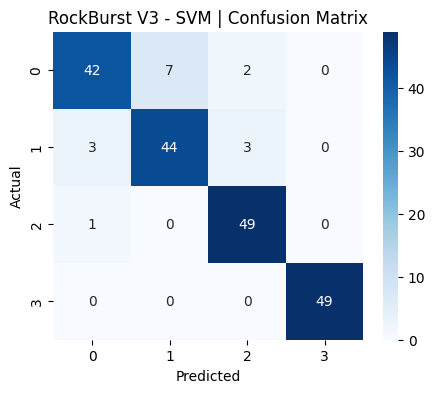


=== RockBurst V3 | XGBoost ===
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        51
           1       0.96      0.92      0.94        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        49

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



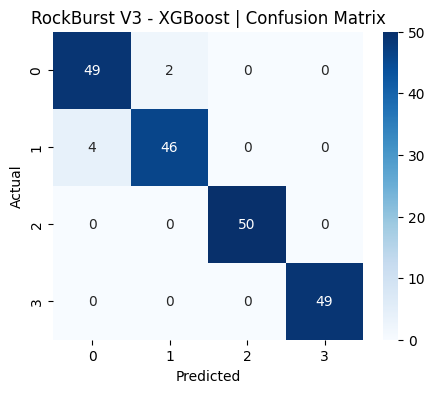

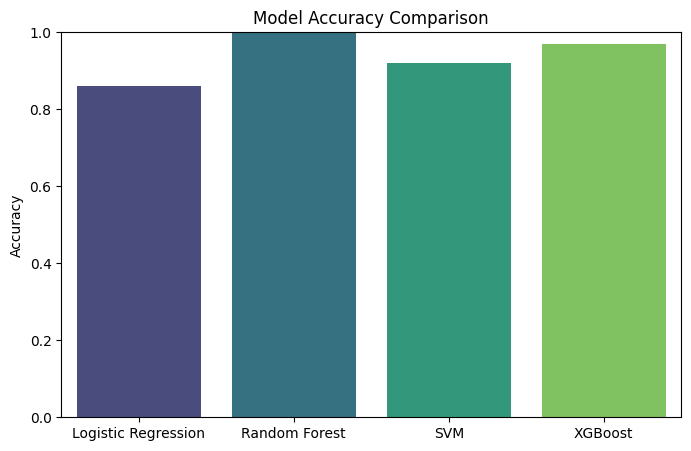

In [70]:
results_df_V3,models_V3,scaler_V3=train_models(df_V3,"RockBurst V3",features_V3)

In [71]:
results_df_V3.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy
1,Random Forest,1.00
3,XGBoost,0.97
2,SVM,0.92
0,Logistic Regression,0.86


In [72]:
results_df_V1['Version'] = 'V1'
results_df_V2['Version'] = 'V2'
results_df_V3['Version'] = 'V3'

results_df_all = pd.concat([results_df_V1, results_df_V2, results_df_V3], ignore_index=True)


In [73]:
results_df_all

,Model,Accuracy,Version
0,Logistic Regression,0.631579,V1
1,Random Forest,0.526316,V1
2,SVM,0.684211,V1
3,XGBoost,0.526316,V1
4,Logistic Regression,0.526316,V2
5,Random Forest,0.473684,V2
6,SVM,0.631579,V2
7,XGBoost,0.578947,V2
8,Logistic Regression,0.860000,V3
9,Random Forest,1.000000,V3


In [74]:
df_wide = results_df_all.pivot(index='Model', columns='Version', values='Accuracy')

In [75]:
df_wide.reindex()

Version,V1,V2,V3
Model,,,
Logistic Regression,0.631579,0.526316,0.86
Random Forest,0.526316,0.473684,1.00
SVM,0.684211,0.631579,0.92
XGBoost,0.526316,0.578947,0.97


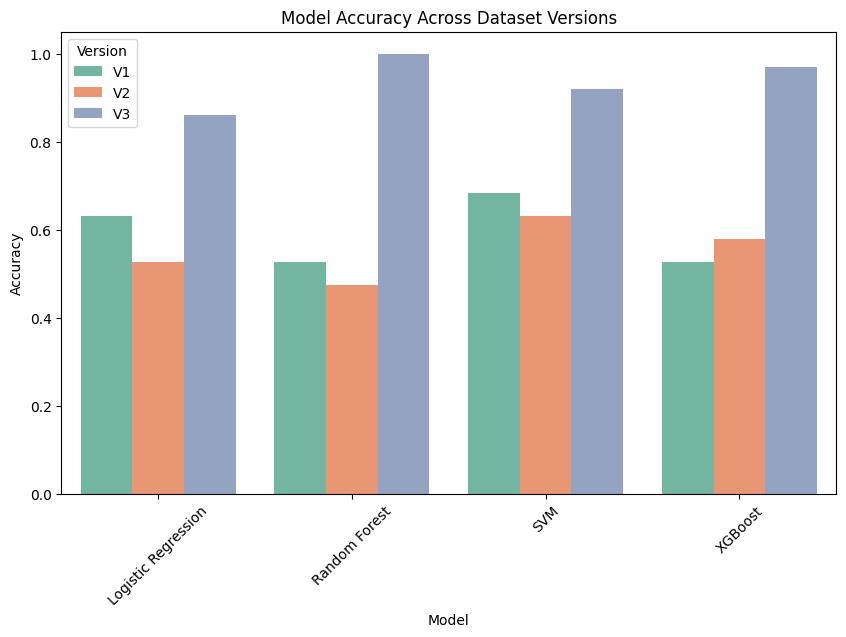

In [76]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df_all, x="Model", y="Accuracy", hue="Version", palette="Set2")
plt.title("Model Accuracy Across Dataset Versions")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.show()


# Saving Best Model

In [77]:
print(type(models_V3))


<class 'dict'>


In [82]:
import joblib

# Save model + features list
joblib.dump((models_V3["XGBoost"], features_V3), "trained_models/xgboost_model_V3.pkl")
joblib.dump((models_V3["Random Forest"],features_V3), "trained_models/Random_Forest_model_V3.pkl")
joblib.dump((models_V3["SVM"],features_V3), "trained_models/SVM_model_V3.pkl")

# Saving Scaler of V3
joblib.dump(scaler_V3, "trained_models/scaler_V3.pkl")


['trained_models/scaler_V3.pkl']

# Applying Cross Validation to check overfitting of best models 

In [79]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

X = df_V3[features_V3]
y = df_V3["Intensity_Level_encoded"]

In [80]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Version 3 Cross-Validation Results")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{name}: Mean Acc = {np.mean(scores):.4f}, Std Dev = {np.std(scores):.4f}, Folds = {scores}")


Version 3 Cross-Validation Results


Logistic Regression: Mean Acc = 0.8960, Std Dev = 0.0086, Folds = [0.905 0.9   0.895 0.88  0.9  ]
Random Forest: Mean Acc = 1.0000, Std Dev = 0.0000, Folds = [1. 1. 1. 1. 1.]
SVM: Mean Acc = 0.8060, Std Dev = 0.0102, Folds = [0.8  0.82 0.81 0.81 0.79]
XGBoost: Mean Acc = 0.9960, Std Dev = 0.0037, Folds = [1.    1.    0.995 0.99  0.995]


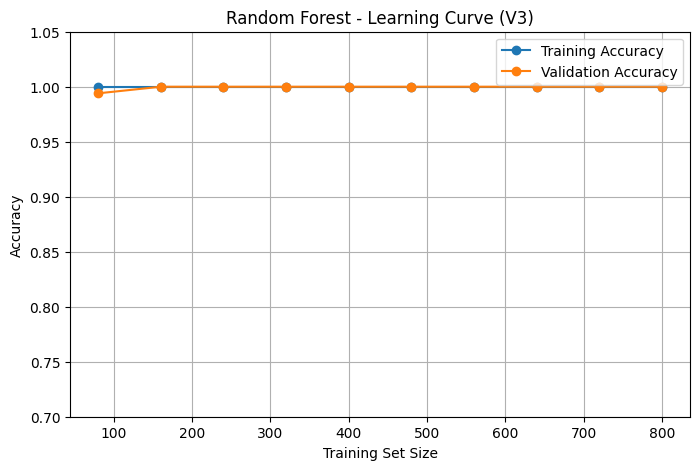

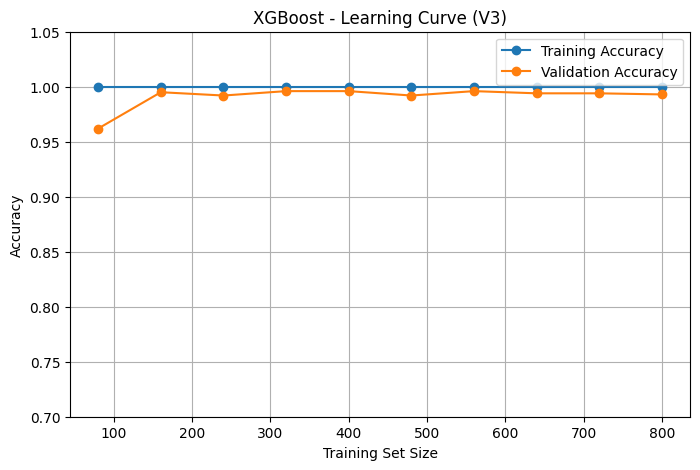

In [81]:
from sklearn.model_selection import learning_curve

#Learning curve function 
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
    plt.plot(train_sizes, test_mean, 'o-', label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.ylim(0.7, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot curves 
plot_learning_curve(RandomForestClassifier(n_estimators=200, random_state=42),
                    X, y, "Random Forest - Learning Curve (V3)")

plot_learning_curve(XGBClassifier(eval_metric='mlogloss', random_state=42),
                    X, y, "XGBoost - Learning Curve (V3)")


# There is no overfitting in models as our data is so strong coorelated and balanced that model generalized very well